# Burgers' Equation

This code is used to reproduce the results presented Section 4.2.1 (Figures A.1(a), A.2, 4.1, 4.2). 

## Preliminary steps

Import modules

In [1]:
%load_ext autoreload
%autoreload 2

from scipy import io
import numpy as np

import matplotlib.pyplot as plt

# plt.style.use("seaborn")

from sklearn.decomposition import PCA

from sklearn.linear_model import Ridge, LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

Load data

In [2]:
data = io.loadmat("../burgers_data/burgers_data_R10.mat")

Train-test split

In [3]:
def get_data(ntrain, ntest):
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = io.loadmat("../burgers_data/burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    
        
    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]
    
    return x_branch_train, y_train, x_branch_test, y_test, grid

To reproduce result shown in Table 4.5, use params `n_train = 1000`, `n_test=200`.

In [4]:
n_train = 1000
n_test = 200

problem = "burgers"

x_train, y_train, x_test, y_test, grid = get_data(n_train, n_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1000, 128) (1000, 128)
(200, 128) (200, 128)


Plot example of training data

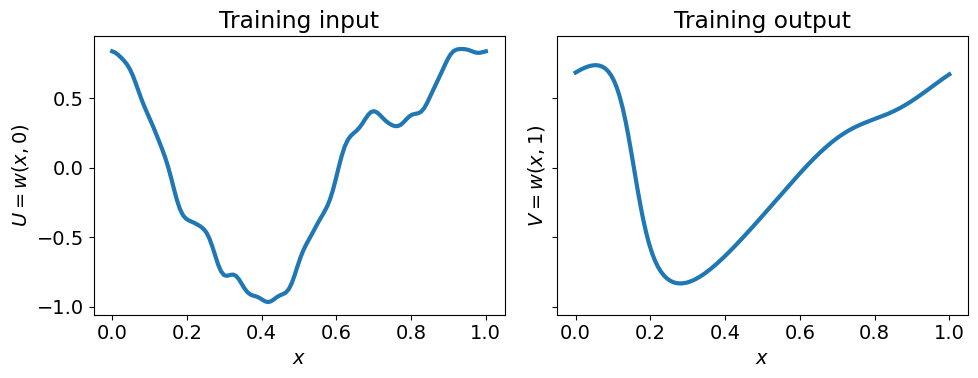

In [5]:
# rc params for line width, font sizes
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["font.size"] = 14

# plot one instance of the training data in a pair of subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey = True)
ax[0].plot(np.linspace(0, 1, 128), x_train[0], label="x", lw = 3)
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$U = w(x, 0)$")
ax[1].plot(np.linspace(0, 1, 128), y_train[0], label="y", lw = 3)
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$V = w(x, 1)$")
# ax[0].legend()
ax[0].set_title("Training input")
ax[1].set_title("Training output")
plt.tight_layout()
plt.savefig("../figures/burgers_training_data.pdf")


Plot PCA results (Figure A.1 (a))

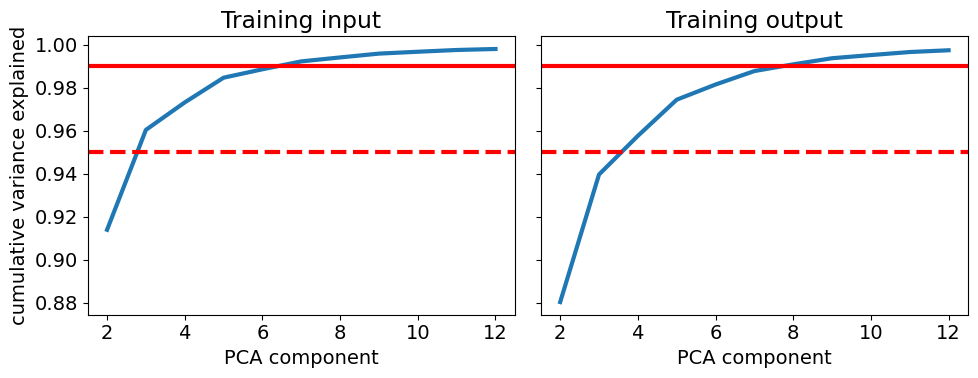

n, m with individually-trained PCAs: (7, 8)


In [34]:
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["font.size"] = 14

large_n = 13 # used as the upper limit of number of PCs to use, set such that it's larger than what's required, must be less than min(n_train, n_features = 128)
x_var_required = 0.99
y_var_required = 0.99

### separate PCAs
x_pca = PCA(n_components = large_n)
x_pca.fit(x_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax[0].plot(range(0, len(np.cumsum(x_pca.explained_variance_ratio_)))[2:], np.cumsum(x_pca.explained_variance_ratio_)[2:])
ax[0].set_ylabel('cumulative variance explained')
ax[0].set_xlabel('PCA component')
ax[0].axhline(0.99, color = 'red')
ax[0].axhline(0.95, color = 'red', linestyle = '--')
ax[0].set_title("Training input")

n = np.where(np.cumsum(x_pca.explained_variance_ratio_) > x_var_required)[0][0]

y_pca = PCA(n_components = large_n)
y_pca.fit(y_train)

ax[1].plot(range(0, len(np.cumsum(y_pca.explained_variance_ratio_)))[2:], np.cumsum(y_pca.explained_variance_ratio_)[2:])
ax[1].set_xlabel('PCA component')
ax[1].axhline(0.99, color = 'red')
ax[1].axhline(0.95, color = 'red', linestyle = '--')
ax[1].set_title("Training output")
plt.tight_layout()
plt.savefig("../figures/burgers_pca_cumsum.pdf")
plt.show()

m = np.where(np.cumsum(y_pca.explained_variance_ratio_) > y_var_required)[0][0]

print(f'n, m with individually-trained PCAs: {n, m}')

Plot PCA weight vectors (Figure A.2)

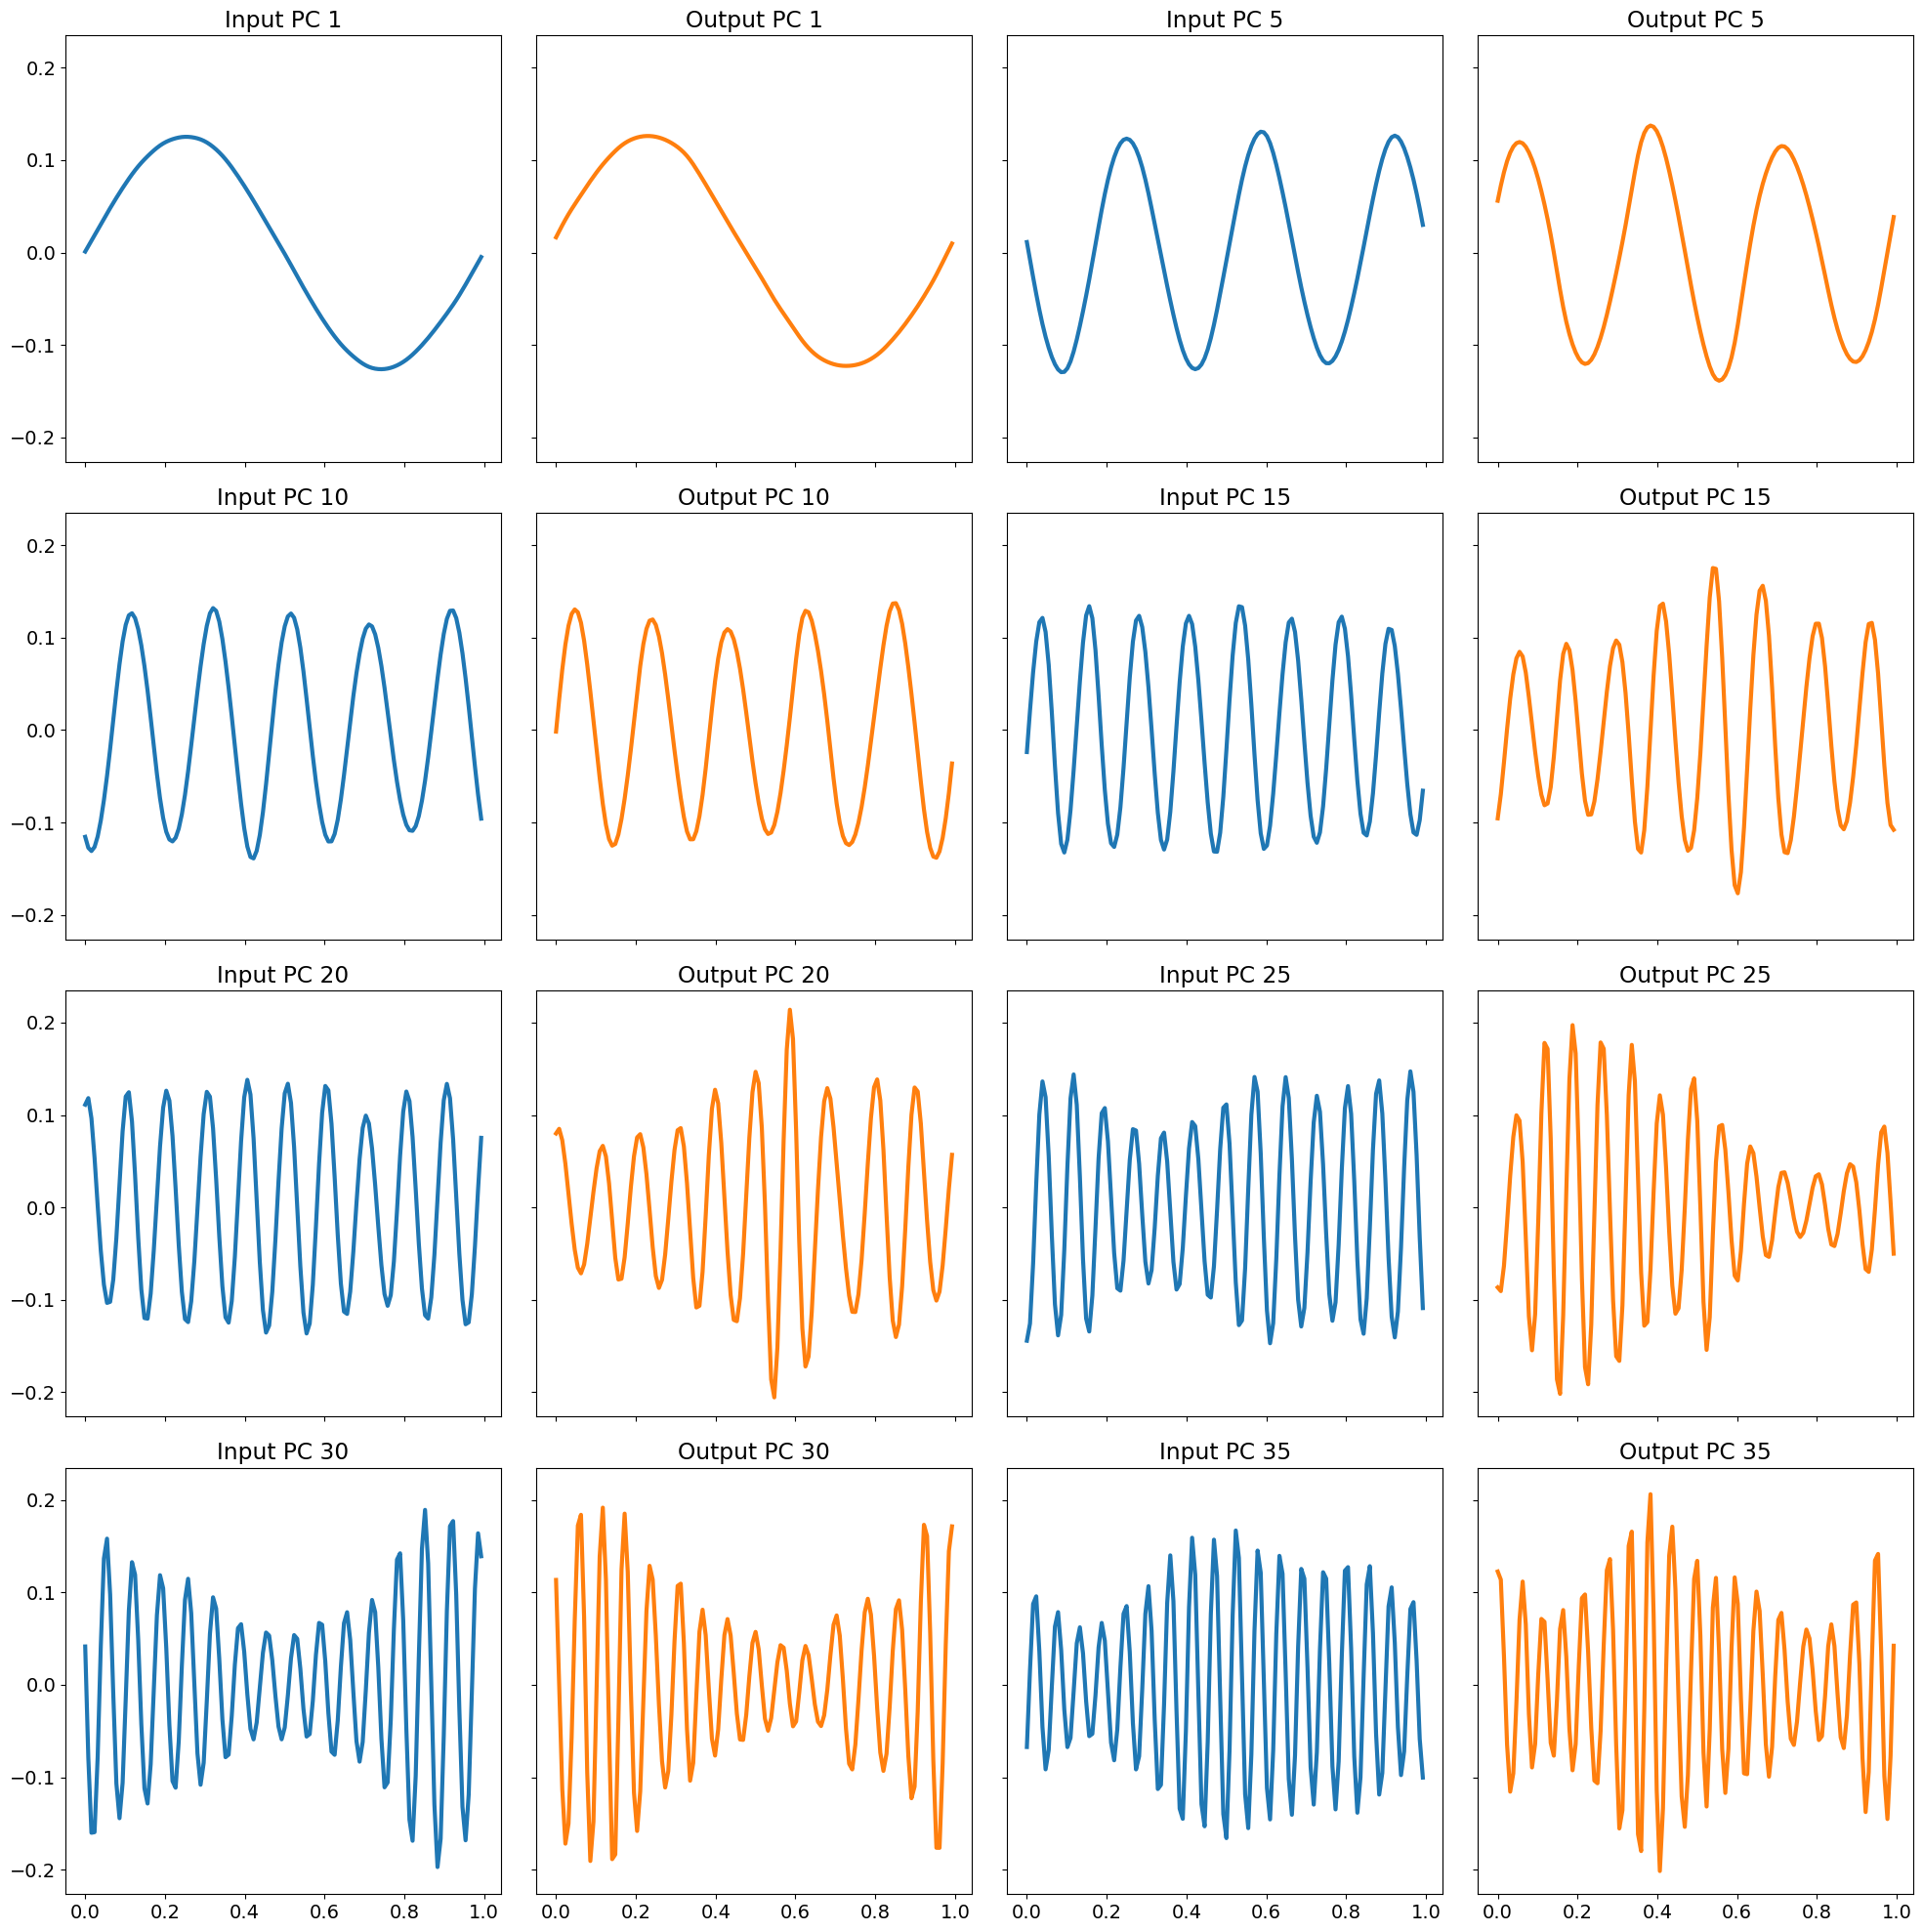

In [35]:
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["font.size"] = 14

x_train_pca = PCA(n_components=50).fit(x_train)
y_train_pca = PCA(n_components=50).fit(y_train)

fig, ax = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
ax = ax.flatten()

c = 0
for i in range(0, 70, 2):
    if i in [0, 8, 18, 28, 38, 48, 58, 68]:
        ax[c].plot(grid, x_train_pca.components_[int(i/2), :])
        ax[c].set_title(f"Input PC {int(i/2)+1}")
        ax[c+1].plot(grid, y_train_pca.components_[int(i/2), :], color = 'tab:orange')
        ax[c+1].set_title(f"Output PC {int(i/2)+1}")
        c = c + 2
plt.tight_layout()
plt.savefig("../figures/burgers_pca_components.pdf")
plt.show()

# corr_list = []
# fig, ax = plt.subplots(7, 5, figsize=(25, 35))
# ax = ax.flatten()
# for i in range(0, 35):
#     ax[i].plot(x_train_pca.components_[i, :], y_train_pca.components_[i, :], marker='o', linestyle='', alpha = 0.2)
#     ax[i].set_xlabel(f"PCA {i+1} x")
#     ax[i].set_ylabel(f"PCA {i+1} y")
#     ax[i].set_title(f"PCA {i+1} x-y comparison")
#     corr_list.append(np.corrcoef(x_train_pca.components_[i, :], y_train_pca.components_[i, :])[0, 1])
# plt.show()

# plt.figure()
# plt.plot(corr_list)
# plt.xlabel('PCA component')
# plt.ylabel('Correlation between x and y')
# plt.show()

## Model definition

In [36]:
import sys
module_dir = '../'
if module_dir not in sys.path:
    sys.path.append(module_dir)
from models import *
import gpjax as gpx

## Train

To reproduce the result in Table 4.5, use params `n = 10, m = 50, ARD = True, multiinput = True, standardise = False, combine_pca = False`.

In [37]:
n_samples = 8

model = full_model(problem = problem, n = 10, m = 50, ARD = True, multiinput = True, standardise = False, combine_pca = False)
train_samples = model.fit(x_train, y_train, n_samples = n_samples)

does x pca
does y pca


  0%|          | 0/50 [00:00<?, ?it/s]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -3675.782477
         Iterations: 47
         Function evaluations: 117
         Gradient evaluations: 105
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([11.55808599, 14.65584445, 14.97269957, 15.67378927, 21.76259539,
       22.16400367, 25.93019525, 25.6314369 , 25.61293324, 28.22233952],      dtype=float64), variance=Array([15.58634245], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


  2%|▏         | 1/50 [00:33<27:05, 33.17s/it]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -3712.015716
         Iterations: 52
         Function evaluations: 93
         Gradient evaluations: 82
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([14.01671293, 12.52683516, 15.03638002, 15.90091405, 22.98194332,
       23.62796746, 26.69867071, 27.70191374, 28.7461789 , 27.55678823],      dtype=float64), variance=Array([18.77366818], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


  4%|▍         | 2/50 [01:04<25:28, 31.85s/it]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -2715.795368
         Iterations: 63
         Function evaluations: 112
         Gradient evaluations: 102
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 8.59746489,  8.81199065,  9.69303995,  9.30069121, 12.91780646,
       14.35516181, 14.54766438, 18.21032778, 19.0131212 , 17.52603672],      dtype=float64), variance=Array([5.1027634], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00340477], dtype=float64))


  6%|▌         | 3/50 [01:50<30:00, 38.30s/it]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -2733.423834
         Iterations: 67
         Function evaluations: 169
         Gradient evaluations: 154
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 8.7049409 ,  8.35033613,  9.37892512,  9.27223434, 14.10086171,
       12.11312537, 16.55664569, 16.80096347, 18.05981304, 17.1669168 ],      dtype=float64), variance=Array([4.55364801], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00317018], dtype=float64))


  8%|▊         | 4/50 [02:41<33:23, 43.56s/it]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -2203.262075
         Iterations: 49
         Function evaluations: 94
         Gradient evaluations: 83
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 6.49134111,  6.00655968,  7.50891913,  7.48716166,  9.66203074,
        8.93616899, 12.47932378, 11.35331112, 14.42623206, 14.17340207],      dtype=float64), variance=Array([1.72766335], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00570012], dtype=float64))


 10%|█         | 5/50 [03:13<29:33, 39.40s/it]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -2220.338236
         Iterations: 45
         Function evaluations: 84
         Gradient evaluations: 72
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 6.40427703,  6.4985606 ,  7.09679379,  7.10011369,  8.48012395,
        9.30170965, 10.97309588, 12.01931632, 14.30869537, 14.42678273],      dtype=float64), variance=Array([1.69341117], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00525571], dtype=float64))


 12%|█▏        | 6/50 [03:42<26:14, 35.78s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -1996.636195
         Iterations: 51
         Function evaluations: 79
         Gradient evaluations: 76
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 5.09913079,  5.00494003,  6.07603705,  6.26961006,  7.75630688,
        8.6633108 , 13.26860914,  8.54679386, 15.39771787, 16.78727555],      dtype=float64), variance=Array([0.85481136], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00663635], dtype=float64))


 14%|█▍        | 7/50 [04:12<24:19, 33.95s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2009.074216
         Iterations: 51
         Function evaluations: 71
         Gradient evaluations: 71
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 5.19973324,  4.85616829,  6.02822498,  5.99993102,  7.56420101,
        7.55119815,  8.41620052, 13.2018102 , 15.8147801 , 12.52811384],      dtype=float64), variance=Array([0.78564052], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00565369], dtype=float64))


 16%|█▌        | 8/50 [04:46<23:50, 34.06s/it]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -1990.816084
         Iterations: 50
         Function evaluations: 91
         Gradient evaluations: 80
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 4.16010384,  4.09102302,  5.2435474 ,  5.15537871,  7.49746302,
        7.58874698, 10.73915623, 10.24412429, 16.71608483, 18.32622215],      dtype=float64), variance=Array([0.40196745], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00463404], dtype=float64))


 18%|█▊        | 9/50 [05:20<23:13, 33.99s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2011.883037
         Iterations: 52
         Function evaluations: 64
         Gradient evaluations: 64
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 4.15323739,  4.14013649,  5.15566657,  5.27527167,  7.29261515,
        7.04815791,  9.1022548 ,  9.05164329, 15.30174383, 16.13303025],      dtype=float64), variance=Array([0.37181331], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00382715], dtype=float64))


 20%|██        | 10/50 [05:44<20:38, 30.96s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2054.910418
         Iterations: 52
         Function evaluations: 70
         Gradient evaluations: 70
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 3.48814917,  3.4798666 ,  4.69580779,  4.82760472,  7.25909311,
        7.31494699, 10.41542162, 11.14689184, 21.74131294, 25.9772802 ],      dtype=float64), variance=Array([0.19827252], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00344917], dtype=float64))


 22%|██▏       | 11/50 [06:17<20:25, 31.43s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2058.900730
         Iterations: 50
         Function evaluations: 99
         Gradient evaluations: 96
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 3.53069104,  3.50445183,  4.68140525,  4.64838029,  6.62771683,
        7.12442538, 11.30584699,  9.66398523, 18.17897375, 20.04392291],      dtype=float64), variance=Array([0.18419523], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00308966], dtype=float64))


 24%|██▍       | 12/50 [06:53<20:42, 32.69s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2147.618635
         Iterations: 63
         Function evaluations: 88
         Gradient evaluations: 88
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 3.01504721,  3.12016916,  4.3474505 ,  4.31675416,  7.27412501,
        7.11734347, 12.83933077, 14.72147839, 25.22808503, 40.71599254],      dtype=float64), variance=Array([0.1088398], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00247549], dtype=float64))


 26%|██▌       | 13/50 [07:24<19:57, 32.35s/it]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -2165.931092
         Iterations: 60
         Function evaluations: 126
         Gradient evaluations: 114
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 3.25436738,  3.05606934,  4.46992664,  4.47150434,  6.98593038,
        6.52021534, 13.66929581, 11.01643838, 40.53374006, 34.34915981],      dtype=float64), variance=Array([0.11166463], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00258574], dtype=float64))


 28%|██▊       | 14/50 [08:06<21:06, 35.18s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2297.506792
         Iterations: 125
         Function evaluations: 159
         Gradient evaluations: 159
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.75580525e+00, 2.78028493e+00, 4.43303268e+00, 4.26771942e+00,
       7.47462730e+00, 7.55179993e+00, 1.71779952e+01, 2.36387280e+01,
       4.35804922e+06, 5.51027791e+01], dtype=float64), variance=Array([0.06595466], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00265928], dtype=float64))


 30%|███       | 15/50 [09:08<25:13, 43.23s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2276.543072
         Iterations: 75
         Function evaluations: 103
         Gradient evaluations: 103
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([ 2.82666905,  2.88308695,  4.25734181,  4.12531157,  7.50615991,
        7.86033927, 16.23368054, 19.02047663, 82.39645756, 70.13037421],      dtype=float64), variance=Array([0.07136366], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.00252245], dtype=float64))


 32%|███▏      | 16/50 [09:58<25:44, 45.44s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2430.218209
         Iterations: 66
         Function evaluations: 72
         Gradient evaluations: 72
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([  2.59059715,   2.60817758,   4.14536926,   3.98062324,
         7.11247929,   6.84616869,  17.61858298,  31.78498645,
        95.10112967, 184.87608403], dtype=float64), variance=Array([0.04063413], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 34%|███▍      | 17/50 [10:32<23:01, 41.87s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2455.708267
         Iterations: 61
         Function evaluations: 93
         Gradient evaluations: 90
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([  2.52110367,   2.53545066,   4.3367305 ,   3.77115633,
         7.60534927,   8.27172542,  21.79696689,  49.24003713,
       178.28213033,  76.06803282], dtype=float64), variance=Array([0.03953581], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 36%|███▌      | 18/50 [11:08<21:21, 40.05s/it]

[1.]
float64


/Users/tomcowperthwaite/opt/anaconda3/envs/mres2/lib/python3.10/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -2602.043710
         Iterations: 56
         Function evaluations: 107
         Gradient evaluations: 96
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([  2.30613764,   2.47469711,   4.39348064,   3.77098255,
         8.86471207,  10.54306356,  25.97563678,  39.86999777,
       110.30955942,  86.80839635], dtype=float64), variance=Array([0.027842], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 38%|███▊      | 19/50 [11:49<20:53, 40.43s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2658.142457
         Iterations: 103
         Function evaluations: 112
         Gradient evaluations: 112
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.31951225e+00, 2.40625431e+00, 3.95196821e+00, 4.05545022e+00,
       9.81863953e+00, 7.51242896e+00, 4.13793828e+01, 6.01675347e+01,
       5.45492145e+06, 6.46760798e+06], dtype=float64), variance=Array([0.02263723], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 40%|████      | 20/50 [12:37<21:21, 42.73s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2739.730484
         Iterations: 101
         Function evaluations: 110
         Gradient evaluations: 110
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.89106591e+00, 2.40817468e+00, 3.93196265e+00, 4.22471404e+00,
       1.03761645e+01, 9.10504842e+00, 4.82874773e+01, 7.92423331e+01,
       5.59079290e+05, 5.29476788e+05], dtype=float64), variance=Array([0.01545246], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 42%|████▏     | 21/50 [13:29<22:00, 45.55s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2838.423702
         Iterations: 69
         Function evaluations: 76
         Gradient evaluations: 76
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([  2.15270012,   2.25166031,   3.80767208,   3.82664058,
        15.69218568,  18.00761815,  40.04437797,  49.2847128 ,
        76.56497734, 152.00083273], dtype=float64), variance=Array([0.01540779], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 44%|████▍     | 22/50 [14:06<20:02, 42.93s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -2955.492895
         Iterations: 108
         Function evaluations: 113
         Gradient evaluations: 113
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.30858540e+00, 1.91045153e+00, 3.69070475e+00, 3.85863442e+00,
       1.46461391e+01, 1.98487929e+01, 6.61656803e+01, 5.13568831e+01,
       3.66842704e+01, 1.23553725e+05], dtype=float64), variance=Array([0.00984969], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 46%|████▌     | 23/50 [15:05<21:28, 47.72s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3096.817683
         Iterations: 102
         Function evaluations: 109
         Gradient evaluations: 109
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.22325844e+00, 1.97600730e+00, 3.68360385e+00, 4.08710696e+00,
       1.81960263e+01, 2.63435446e+01, 6.03512256e+01, 5.66191229e+04,
       6.21079476e+04, 8.36953065e+01], dtype=float64), variance=Array([0.00853844], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 48%|████▊     | 24/50 [15:59<21:29, 49.58s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3346.604913
         Iterations: 134
         Function evaluations: 152
         Gradient evaluations: 152
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.04322162e+00, 2.04888576e+00, 4.23113538e+00, 5.13968988e+00,
       7.23772366e+01, 5.63762499e+01, 7.54919799e+01, 1.52384828e+02,
       1.39692798e+06, 3.97363959e+06], dtype=float64), variance=Array([0.00847825], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 50%|█████     | 25/50 [17:21<24:40, 59.23s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3152.904710
         Iterations: 91
         Function evaluations: 100
         Gradient evaluations: 100
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.80454557e+00, 2.04341699e+00, 3.60579263e+00, 4.31018726e+00,
       8.09708103e+00, 1.32457493e+01, 2.05449212e+06, 2.91350370e+01,
       1.46122164e+06, 1.43165767e+06], dtype=float64), variance=Array([0.00406773], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 52%|█████▏    | 26/50 [18:14<23:03, 57.64s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3381.248721
         Iterations: 101
         Function evaluations: 107
         Gradient evaluations: 107
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.94332624e+00, 1.90804208e+00, 4.25193150e+00, 3.88009255e+00,
       1.03347948e+01, 4.97868479e+01, 6.30745467e+01, 6.33120338e+01,
       9.88682042e+04, 9.07287689e+04], dtype=float64), variance=Array([0.00332227], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 54%|█████▍    | 27/50 [19:11<21:58, 57.33s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3443.842145
         Iterations: 129
         Function evaluations: 136
         Gradient evaluations: 136
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.98836700e+00, 1.89311428e+00, 3.80229230e+00, 4.73549127e+00,
       2.14116656e+01, 2.56317666e+01, 1.33174964e+02, 8.69934569e+01,
       4.09978177e+05, 2.87760284e+05], dtype=float64), variance=Array([0.00355454], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 56%|█████▌    | 28/50 [20:37<24:10, 65.94s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3559.444826
         Iterations: 86
         Function evaluations: 91
         Gradient evaluations: 91
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.91315069e+00, 1.64875241e+00, 4.55763588e+00, 5.76896120e+00,
       3.40814889e+01, 2.31252242e+01, 1.28618349e+05, 1.63467754e+05,
       1.76213245e+05, 2.59683491e+05], dtype=float64), variance=Array([0.00291379], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 58%|█████▊    | 29/50 [21:21<20:46, 59.38s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3681.447377
         Iterations: 145
         Function evaluations: 175
         Gradient evaluations: 175
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.60419438e+00, 2.02431618e+00, 4.86434960e+00, 6.17268664e+00,
       2.19006981e+01, 1.56590839e+01, 1.19779743e+06, 7.21457470e+01,
       1.39021386e+06, 8.52662290e+01], dtype=float64), variance=Array([0.00213584], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 60%|██████    | 30/50 [23:02<23:53, 71.66s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3710.113719
         Iterations: 78
         Function evaluations: 85
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.52692365e+00, 2.17014945e+00, 3.57226725e+00, 6.07737684e+00,
       1.10238348e+01, 1.48172714e+01, 1.01267519e+05, 6.84326540e+04,
       3.47880187e+04, 5.05255170e+04], dtype=float64), variance=Array([0.00124601], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 62%|██████▏   | 31/50 [23:47<20:11, 63.75s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -3752.466635
         Iterations: 75
         Function evaluations: 85
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.44951059e+00, 2.22845206e+00, 4.07348809e+00, 4.54647598e+00,
       1.12914032e+01, 1.57285682e+01, 5.58816997e+05, 5.14588314e+05,
       3.11939314e+05, 3.36276137e+05], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 64%|██████▍   | 32/50 [24:26<16:53, 56.31s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4054.388958
         Iterations: 95
         Function evaluations: 108
         Gradient evaluations: 108
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.97825428e+00, 2.08454230e+00, 5.14866009e+00, 7.21545156e+00,
       2.14956327e+01, 2.02788284e+01, 1.25331656e+06, 1.22504822e+06,
       9.27674587e+05, 1.25072710e+06], dtype=float64), variance=Array([0.00131389], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 66%|██████▌   | 33/50 [25:20<15:45, 55.62s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4062.300878
         Iterations: 105
         Function evaluations: 120
         Gradient evaluations: 120
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.92369937e+00, 1.83148704e+00, 4.54504703e+00, 6.33960021e+00,
       5.43599299e+06, 1.48003509e+07, 4.52849844e+06, 3.68051035e+06,
       3.09785757e+06, 1.88743221e+06], dtype=float64), variance=Array([0.0010981], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 68%|██████▊   | 34/50 [26:18<15:01, 56.32s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4159.751235
         Iterations: 114
         Function evaluations: 131
         Gradient evaluations: 131
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.02179140e+00, 2.52298743e+00, 4.26635727e+00, 7.48438867e+00,
       2.33779368e+01, 3.19279043e+01, 2.05694894e+05, 2.31880741e+05,
       5.01804639e+04, 9.10362195e+04], dtype=float64), variance=Array([0.00139743], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 70%|███████   | 35/50 [27:24<14:49, 59.30s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4401.984697
         Iterations: 112
         Function evaluations: 130
         Gradient evaluations: 130
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.26018154e+00, 2.11860740e+00, 1.01532668e+01, 2.95812105e+01,
       6.60434139e+05, 6.52210758e+05, 2.73895005e+05, 6.67652302e+05,
       5.22122609e+05, 6.11155508e+05], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 72%|███████▏  | 36/50 [28:27<14:06, 60.49s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4380.387309
         Iterations: 130
         Function evaluations: 147
         Gradient evaluations: 147
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.94147982e+00, 2.57415563e+00, 4.94398246e+00, 1.19243135e+01,
       3.66528634e+01, 4.34748378e+01, 6.65084614e+04, 9.82448834e+01,
       1.31222812e+05, 9.24773207e+04], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 74%|███████▍  | 37/50 [29:45<14:11, 65.52s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4557.664685
         Iterations: 114
         Function evaluations: 126
         Gradient evaluations: 126
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.16918315e+00, 2.47311259e+00, 6.75141843e+00, 1.19209081e+01,
       6.91147663e+01, 9.68886991e+01, 1.68998880e+06, 2.17551785e+06,
       2.91235531e+06, 1.03329984e+06], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 76%|███████▌  | 38/50 [30:40<12:30, 62.55s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4572.230413
         Iterations: 119
         Function evaluations: 128
         Gradient evaluations: 128
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.04294883e+00, 1.84884458e+00, 8.33569796e+00, 4.89215335e+01,
       1.68162154e+06, 1.08194191e+02, 2.42016607e+06, 1.03341614e+06,
       1.04847091e+06, 3.17528214e+05], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 78%|███████▊  | 39/50 [31:45<11:36, 63.35s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4578.969328
         Iterations: 102
         Function evaluations: 117
         Gradient evaluations: 117
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.82128297e+00, 2.94713551e+00, 4.63673403e+00, 6.88464308e+00,
       6.93922680e+06, 3.94597684e+01, 1.14286747e+07, 7.48839208e+06,
       6.72649955e+06, 7.50220310e+06], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 80%|████████  | 40/50 [32:46<10:25, 62.52s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4628.380004
         Iterations: 117
         Function evaluations: 131
         Gradient evaluations: 131
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.08214579e+00, 2.87898078e+00, 1.92043645e+01, 6.80511795e+00,
       2.42366404e+01, 1.30049992e+02, 1.00157393e+06, 1.46766758e+06,
       3.89485031e+05, 1.74907351e+06], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 82%|████████▏ | 41/50 [33:49<09:22, 62.54s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4706.496524
         Iterations: 112
         Function evaluations: 121
         Gradient evaluations: 121
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([3.30037667e+00, 5.90448894e+00, 8.78886117e+00, 3.99403690e+00,
       5.16560450e+01, 2.96315410e+02, 2.49884807e+06, 3.11776587e+00,
       1.90416147e+06, 1.64041514e+06], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 84%|████████▍ | 42/50 [34:46<08:09, 61.14s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4828.876895
         Iterations: 83
         Function evaluations: 92
         Gradient evaluations: 92
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.27985850e+00, 7.23706208e+00, 2.56124147e+01, 4.33800538e+00,
       5.52794708e+00, 2.46383018e+06, 1.61008953e+06, 1.32798751e+06,
       1.29524788e+06, 1.28248200e+06], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 86%|████████▌ | 43/50 [35:33<06:36, 56.65s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4994.648640
         Iterations: 76
         Function evaluations: 86
         Gradient evaluations: 86
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([3.36598919e+00, 2.76575643e+00, 1.34727446e+01, 3.26429539e+01,
       7.09850437e+05, 9.95450783e+05, 9.18004351e+05, 1.14822388e+05,
       6.67981211e+05, 9.23919366e+05], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 88%|████████▊ | 44/50 [36:13<05:10, 51.77s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -4921.064952
         Iterations: 90
         Function evaluations: 105
         Gradient evaluations: 105
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([2.76914436e+00, 2.74415983e+00, 6.66660108e+06, 1.03082264e+06,
       5.30191545e+06, 1.32243013e+07, 1.38514041e+07, 6.00041248e+00,
       7.24064476e+06, 8.03342781e+00], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 90%|█████████ | 45/50 [36:57<04:06, 49.39s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -5014.061783
         Iterations: 78
         Function evaluations: 92
         Gradient evaluations: 92
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([9.96436265e+00, 5.75785124e+00, 7.90928586e+00, 1.53672561e+01,
       1.58909978e+05, 1.06475320e+05, 3.67661469e+04, 1.50457361e+05,
       1.23723740e+05, 7.85682399e-01], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 92%|█████████▏| 46/50 [37:42<03:11, 48.00s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -5086.021352
         Iterations: 77
         Function evaluations: 85
         Gradient evaluations: 85
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.41003768e+00, 7.10911367e+00, 1.26614065e+01, 1.52699755e+06,
       1.99767473e+05, 3.05171946e+06, 9.19403029e+05, 1.81215641e+00,
       1.26540813e+06, 2.45499394e+06], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 94%|█████████▍| 47/50 [38:26<02:20, 46.82s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -5095.453066
         Iterations: 58
         Function evaluations: 76
         Gradient evaluations: 76
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([1.23909489e+01, 3.51526923e+00, 5.86653517e+02, 1.44884811e+04,
       3.18183923e+04, 1.62386863e+04, 3.76798826e+04, 2.81758800e+04,
       4.74063314e+00, 3.15463123e+00], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 96%|█████████▌| 48/50 [39:01<01:26, 43.45s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -5223.344072
         Iterations: 123
         Function evaluations: 157
         Gradient evaluations: 157
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([5.42374436e+00, 8.22828860e+00, 1.81262510e+02, 8.68368418e+02,
       5.79265886e+04, 5.02519838e+04, 7.00421188e+04, 1.83738654e+00,
       5.25145983e+04, 5.35055324e+04], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


 98%|█████████▊| 49/50 [40:09<00:50, 50.90s/it]

[1.]
float64
Optimization terminated successfully.
         Current function value: -5223.904763
         Iterations: 80
         Function evaluations: 93
         Gradient evaluations: 93
Prior(kernel=RBF(compute_engine=DenseKernelComputation(), active_dims=None, name='RBF', lengthscale=Array([8.93510008e+00, 7.24074498e+00, 1.54470877e+06, 3.15534528e+06,
       5.34165279e+06, 1.24331389e+07, 9.99799728e+06, 1.71027970e+00,
       5.22472821e+06, 9.47785374e+06], dtype=float64), variance=Array([0.001], dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06)
Gaussian(num_datapoints=1000, integrator=AnalyticalGaussianIntegrator(), obs_stddev=Array([0.001], dtype=float64))


100%|██████████| 50/50 [40:52<00:00, 49.06s/it]


## Assess performance on training data

100%|██████████| 50/50 [01:03<00:00,  1.26s/it]


median relative L2 (train data): 0.0018443684096511007
mean relative L2 (train data): 0.0023107190043995386


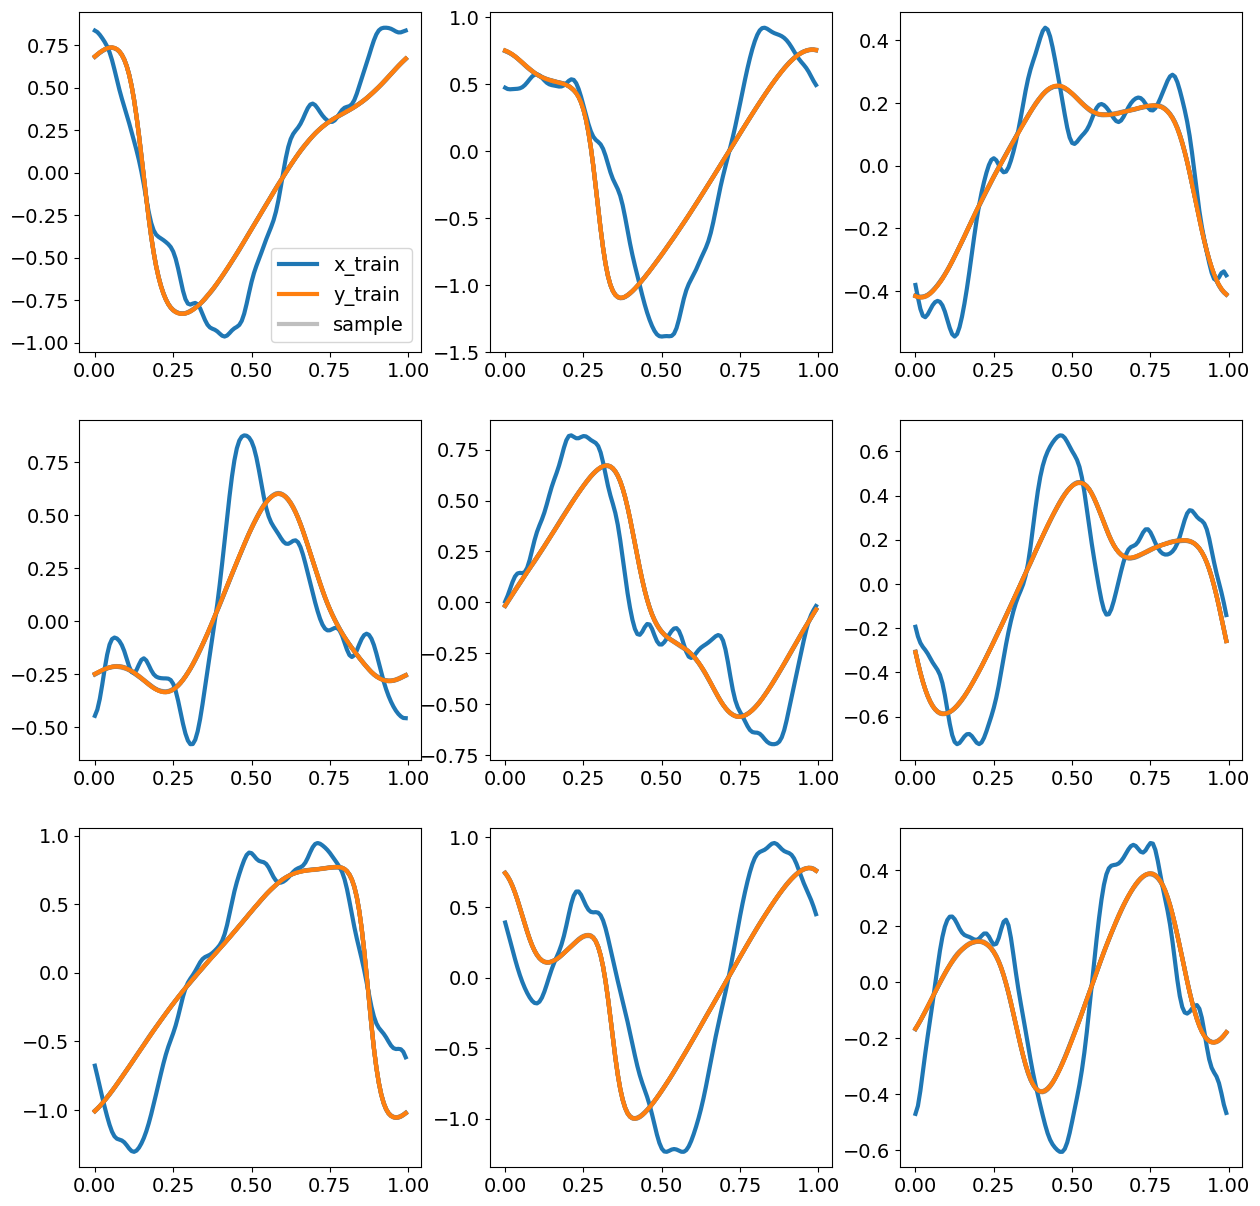

In [38]:
n_samples = 8

y_pred_train, train_samples = model.predict(x_train, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred_train - y_train, axis = -1)/np.linalg.norm(y_train, axis = -1)

print(f'median relative L2 (train data): {np.median(relative_L2)}')
print(f'mean relative L2 (train data): {np.mean(relative_L2)}')

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
for i in range(9):
    ax[i].plot(grid, x_train[i], label='x_train')
    ax[i].plot(grid, y_train[i], label='y_train')
    for j in range(n_samples):
        ax[i].plot(grid, train_samples[i, :, j], label='sample', color = 'grey', alpha = 0.5, zorder = 0)
        if i == 0 and j == 0:
            ax[i].legend()
plt.show()

## Test

Reproduce Figure 4.1

100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


median relative L2: 0.011247874317951755
mean relative L2: 0.015160861769047096
median R2: 0.9994566209907929
mean R2: 0.9987459800221274


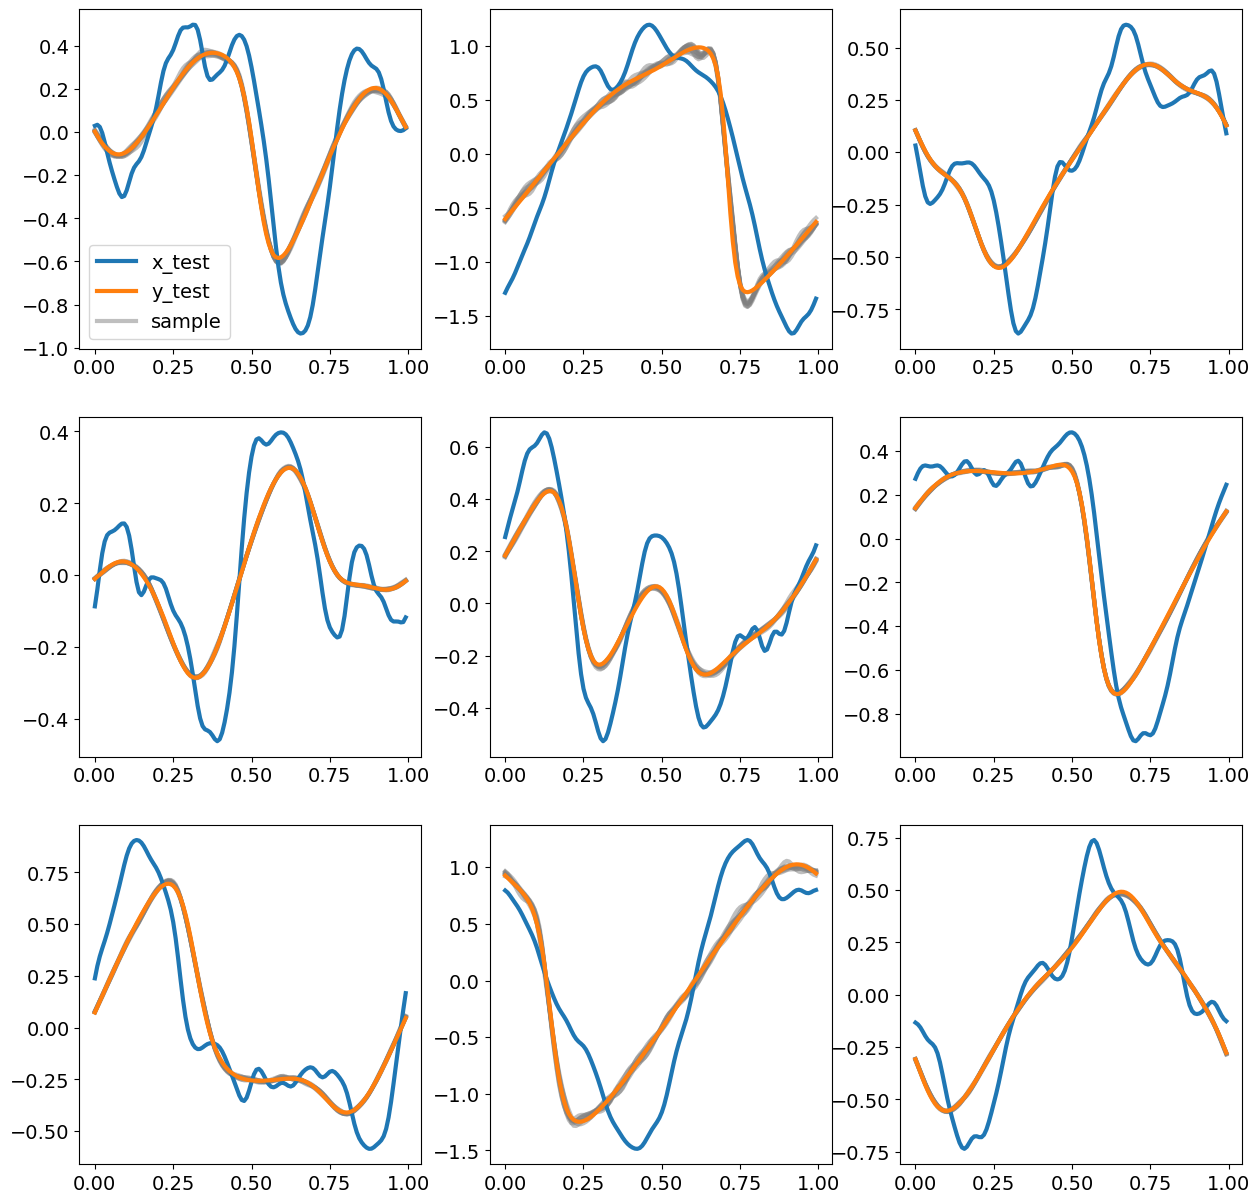

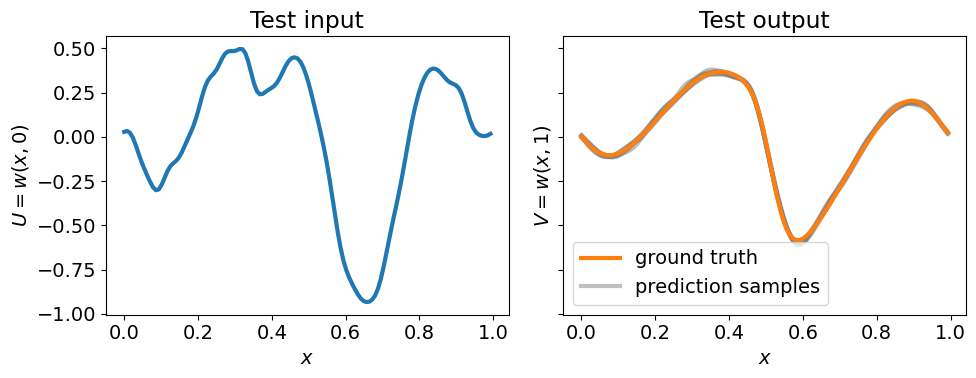

In [39]:
n_samples = 8

y_pred, test_samples = model.predict(x_test, n_samples = n_samples)

relative_L2 = np.linalg.norm(y_pred - y_test, axis = -1)/np.linalg.norm(y_test, axis = -1)
R2 = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

print(f'median relative L2: {np.median(relative_L2)}')
print(f'mean relative L2: {np.mean(relative_L2)}')
print(f'median R2: {np.median(R2)}')
print(f'mean R2: {np.mean(R2)}')

mean = np.mean(relative_L2)

fig, ax = plt.subplots(3, 3, figsize = (15, 15))
ax = ax.flatten()
for i in range(9):
    ax[i].plot(grid, x_test[i], label='x_test')
    ax[i].plot(grid, y_test[i], label='y_test')
    for j in range(n_samples):
        ax[i].plot(grid, test_samples[i, :, j], label='sample', color = 'grey', alpha = 0.5, zorder = 0)
        if i == 0 and j == 0:
            ax[i].legend()
plt.show()

index_to_plot = 0

# plot one instance of the test results in a pair of subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey = True)
ax[0].plot(grid, x_test[index_to_plot])
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$U = w(x, 0)$")
ax[1].plot(grid, y_test[index_to_plot], label='ground truth', color = 'tab:orange')
for i in range(n_samples):
    ax[1].plot(grid, test_samples[index_to_plot, :, i], label='prediction samples', color = 'grey', alpha = 0.5, zorder = 0)
    if i == 0: ax[1].legend()
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$V = w(x, 1)$")
ax[0].set_title("Test input")
ax[1].set_title("Test output")
plt.tight_layout()
plt.savefig("../figures/burgers_test_result.pdf")

Take 100 samples to empirically determine uncertainty

In [40]:
n_samples = 100
y_pred, test_samples = model.predict(x_test, n_samples = n_samples)


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


In [41]:
test_samples_mean = np.mean(test_samples, axis = 2)
test_samples_std = np.std(test_samples, axis = 2)

Plot example test output with uncertainty (Figure 4.2)

(200, 128) (200, 128) (200, 128)


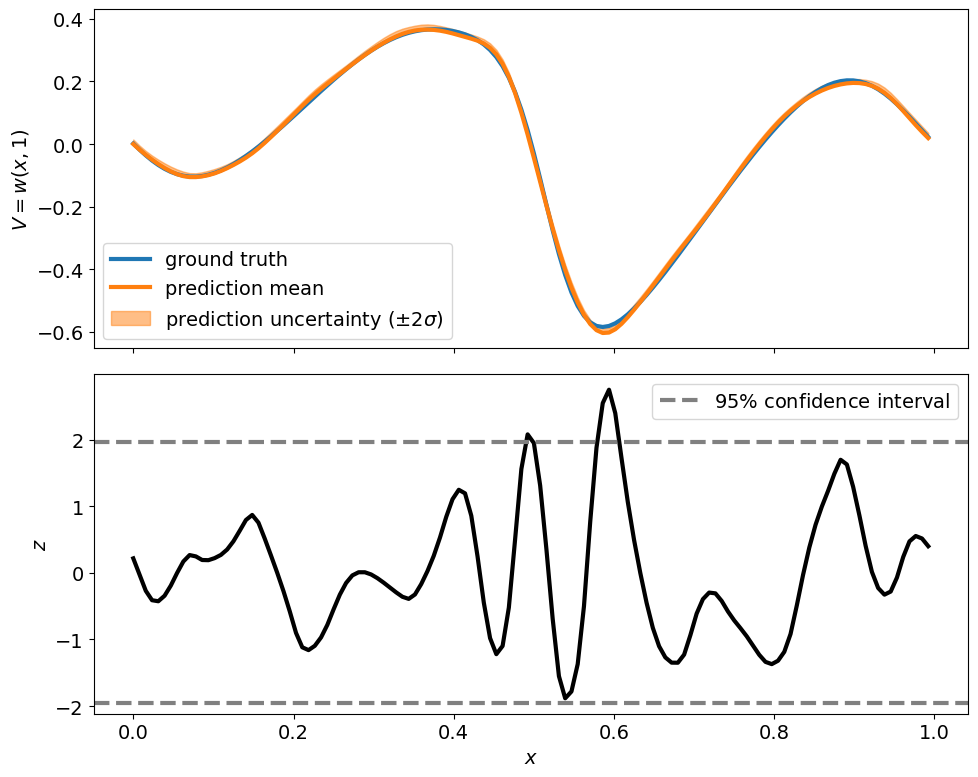

mean NLPD: 212.69861548779997
mean adapted NLPD: 1.6617079334984373
(200, 128)
(23020,)
percentage of z-scores within 95% confidence interval: 0.89921875


In [68]:
def z_score_to_pdf(z):
    """
    Calculate the probability density function (PDF) value for a given z-score
    in the standard normal distribution.

    Parameters:
    z (float): The z-score for which to calculate the PDF value.

    Returns:
    float: The PDF value corresponding to the given z-score.
    """
    pdf_value = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)
    return pdf_value

index_to_plot = 0

fig, ax = plt.subplots(2, 1, figsize = (10, 8), sharex = True)
ax = ax.flatten()

print(y_test.shape, test_samples_mean.shape, test_samples_std.shape)
ax[0].plot(grid, y_test[index_to_plot, :], label='ground truth', color = 'tab:blue')
ax[0].plot(grid, test_samples_mean[index_to_plot, :], color='tab:orange', label='prediction mean')
ax[0].fill_between(grid[:, 0], test_samples_mean[index_to_plot, :], test_samples_mean[index_to_plot, :]+2*test_samples_std[index_to_plot, :], test_samples_mean[index_to_plot, :]-2*test_samples_std[index_to_plot, :], color='tab:orange', alpha = 0.5, label=r'prediction uncertainty ($\pm 2\sigma$)')
# ax[0].set_title("Ground truth output")
ax[0].set_ylabel(r"$V = w(x, 1)$")
ax[0].legend()

z_scores = (y_test - test_samples_mean) / test_samples_std

ax[1].plot(grid, z_scores[index_to_plot, :], color = 'k')
# ax[1].set_title(f"Prediction z-score")
ax[1].set_xlabel(r"$x$")
ax[1].set_ylabel(r"$z$")
ax[1].axhline(1.96, color = 'grey', linestyle = '--')
ax[1].axhline(-1.96, color = 'grey', linestyle = '--', label=r'$95\%$ confidence interval')
ax[1].legend()

plt.tight_layout()
plt.savefig(f"../figures/burgers_test_result_uncertainty.pdf")
plt.show()

# calculate NLPD
z_scores = (y_test - test_samples_mean) / test_samples_std
probabilities = z_score_to_pdf(z_scores)
NLPD = -np.sum(np.log(probabilities), axis = 1)
mean_NLPD = np.mean(NLPD)
print(f'mean NLPD: {mean_NLPD}')

adapted_NLPD = -np.mean(np.log(probabilities), axis = 1)
mean_adapted_NLPD = np.mean(adapted_NLPD)
print(f'mean adapted NLPD: {mean_adapted_NLPD}')

z_scores_within_conf = z_scores[abs(z_scores) - 1.96 < 0]
print(z_scores.shape)
print(z_scores_within_conf.shape)

print(f'percentage of z-scores within 95% confidence interval: {z_scores_within_conf.shape[0]/(z_scores.shape[0]*z_scores.shape[1])}')